In [1]:
from feature_engine.datetime import DatetimeFeatures
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, SplineTransformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
import sys
from xgboost import XGBRegressor

sys.path.append(str(Path().absolute().parent.parent))

from tsml.train.trainer import TSTrainer, CustomTimeSeriesSplit

/Users/ignaciomarin/Documents/proyectos/TSML/venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
# df = pd.read_parquet('../../data/walmart/processed/cat_id_sales.parquet').replace(-1, np.nan).dropna()
df = pd.read_parquet('../../data/walmart/processed/dept_id_sales.parquet').dropna()
df.head(8)

dept_id       date event_name_1 event_name_2  snap_CA  snap_TX  snap_WI  \
29  FOODS_1 2011-02-27         None         None        0        0        0   
30  FOODS_1 2011-02-28         None         None        0        0        0   
31  FOODS_1 2011-03-01         None         None        1        1        0   
32  FOODS_1 2011-03-02         None         None        1        0        1   
33  FOODS_1 2011-03-03         None         None        1        1        1   
34  FOODS_1 2011-03-04         None         None        1        0        0   
35  FOODS_1 2011-03-05         None         None        1        1        1   
36  FOODS_1 2011-03-06         None         None        1        1        1   

     y_0     y_1     y_2  ...     y_9    y_10    y_11    y_12    y_13  \
29  2019  1464.0  1691.0  ...  1456.0  1482.0  1564.0  1868.0  2275.0   
30  1464  1691.0  1588.0  ...  1482.0  1564.0  1868.0  2275.0  1926.0   
31  1691  1588.0  1626.0  ...  1564.0  1868.0  2275.0  1926.0  1635.0   
32  1588  1626.0  1759.0  ...  1868.0  2275.0  1926.0  1635.0  1623.0   
33  1626  1759.0  2193.0  ...  2275.0  1926.0  1635.0  1623.0  1636.0   
34  1759  2193.0  2301.0  ...  1926.0  1635.0  1623.0  1636.0  1452.0   
35  2193  2301.0  1540.0  ...  1635.0  1623.0  1636.0  1452.0  1787.0   
36  2301  1540.0  1456.0  ...  1623.0  1636.0  1452.0  1787.0  2163.0   

    y_0_mean_roll_7  y_0_mean_roll_30  y_0_lag_1  y_0_lag_7  is_censored  
29      1798.285714       1963.566667     2432.0     2164.0            0  
30      1752.571429       1934.266667     2019.0     1784.0            0  
31      1782.714286       1916.766667     1464.0     1480.0            0  
32      1782.857143       1914.466667     1691.0     1587.0            0  
33      1794.857143       1918.400000     1588.0     1542.0            0  
34      1797.000000       1936.733333     1626.0     1744.0            0  
35      1762.857143       1946.600000     1759.0     2432.0            0  
36      1803.142857       1959.866667     2193.0     2019.0            0  

[8 rows x 26 columns]

In [5]:
def multi_ts_train_test_split(X, y, window_split): ## test_size equal to the time horizon. Splits defines the rest
        if isinstance(X.index, pd.core.indexes.range.RangeIndex):
            idx_u = np.unique(X.index.values)
        else: 
            idx_u = X.index.unique()

        train_index = idx_u[ : -window_split]
        test_index  = idx_u[ -window_split : ]
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        return X_train, X_test, y_train, y_test

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation='periodic',
        include_bias=True,
    )

In [6]:
targets = ['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7','y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13']
X_train, X_test, y_train, y_test = \
    multi_ts_train_test_split(df.set_index('date', drop=False), df.set_index('date', drop=False)[targets], 28)

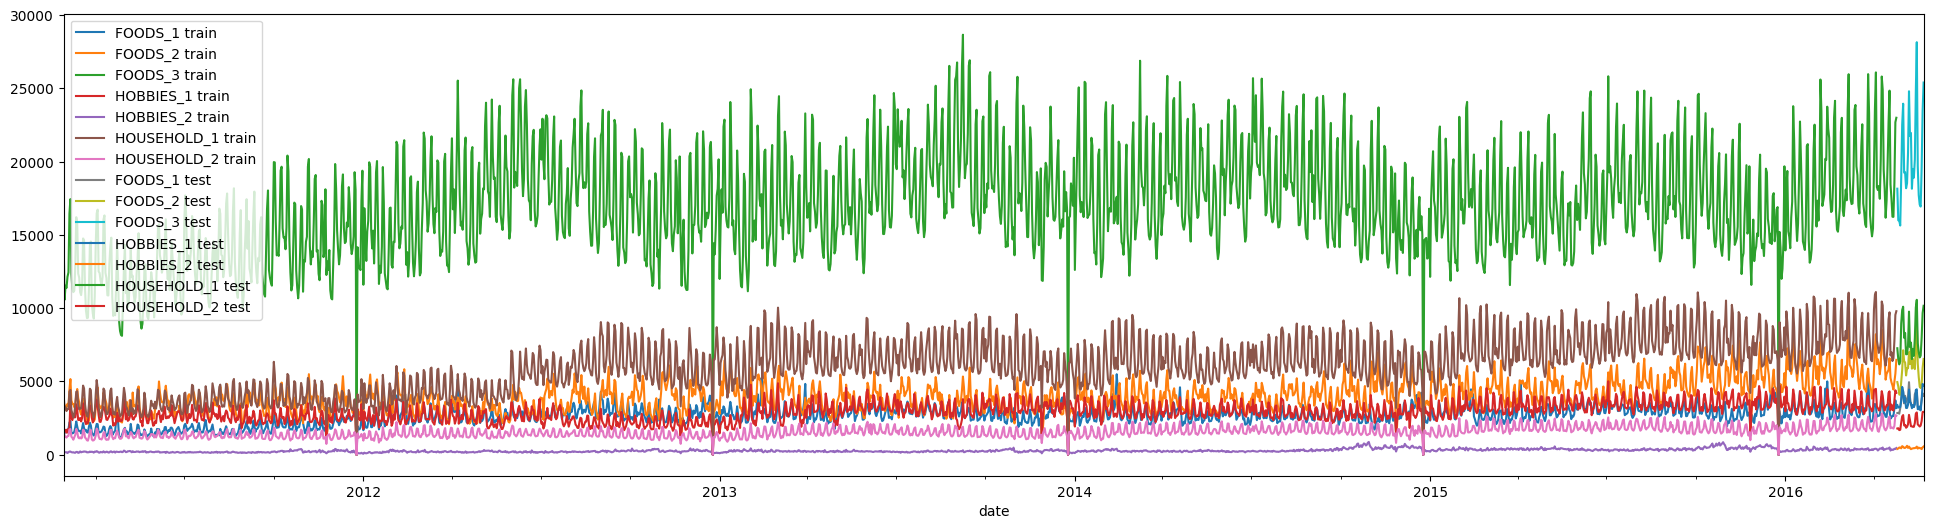

In [7]:
fig, ax= plt.subplots(figsize=(24,6))
for name, group in X_train.groupby('dept_id'):
    group.plot(y = 'y_0', ax=ax, label=f'{name} train')
for name, group in X_test.groupby('dept_id'):
    group.plot(y = 'y_0', ax=ax, label=f'{name} test')
plt.show()

In [11]:
categorical_columns_ohe = ['dept_id'] # Try extract category, not department -> preprocess
categorical_columns_ordinal = ['event_name_1', 'event_name_2']
date_column = ['date']
targets = ['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7','y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13']

dt_transform = DatetimeFeatures(
    variables='date',
    features_to_extract=['year','month','week','day_of_week', 'day_of_month']
)

ohe = OneHotEncoder()
ordinal = OrdinalEncoder()

transformer_1 = ColumnTransformer(
        transformers=[
            ('date_transform', dt_transform, date_column),
            ('categorical-ordinal', ordinal, categorical_columns_ordinal),
            ('categorical-ohe', ohe, categorical_columns_ohe),
            ('drop', 'drop', targets)
        ],
        remainder='passthrough',
    )

transformer_2 = make_pipeline(
    dt_transform,
    ColumnTransformer(
        transformers=[
            ('cyclic_month', periodic_spline_transformer(12, n_splines=6),  ['date_month']),
            ('cyclic_weekday', periodic_spline_transformer(7, n_splines=3), ['date_day_of_week']),
            ('cyclic_week', periodic_spline_transformer(52, n_splines=24),  ['date_week']),
            ('categorical-ordinal', ordinal, categorical_columns_ordinal),
            ('categorical-ohe', ohe, categorical_columns_ohe),
            ('drop', 'drop', targets)
        ],
        remainder='passthrough',
    )
)

xgb_pipeline_1 = make_pipeline(transformer_1, XGBRegressor())
xgb_pipeline_2 = make_pipeline(transformer_2, XGBRegressor())
lgbm_pipeline_1 = make_pipeline(transformer_1,LGBMRegressor())
lgbm_pipeline_2 = make_pipeline(transformer_2,LGBMRegressor())

(15,)
['cyclic_week__date_week_sp_0' 'cyclic_week__date_week_sp_1'
 'cyclic_week__date_week_sp_2' 'cyclic_week__date_week_sp_3'
 'cyclic_week__date_week_sp_4' 'cyclic_week__date_week_sp_5'
 'cyclic_week__date_week_sp_6' 'cyclic_week__date_week_sp_7'
 'cyclic_week__date_week_sp_8' 'cyclic_week__date_week_sp_9'
 'cyclic_week__date_week_sp_10' 'cyclic_week__date_week_sp_11'
 'cyclic_week__date_week_sp_12' 'cyclic_week__date_week_sp_13'
 'cyclic_week__date_week_sp_14']


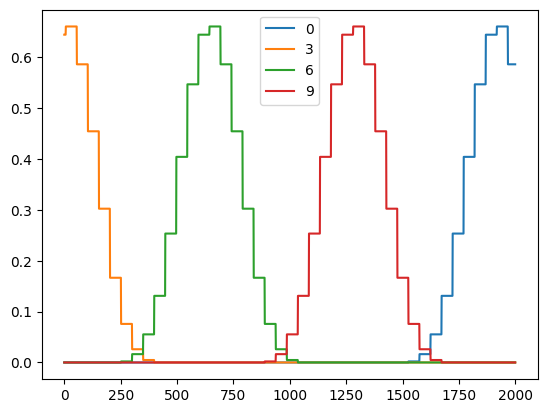

In [12]:

transformer_3 = make_pipeline(
    dt_transform,
    ColumnTransformer(
        transformers=[
            # ('cyclic_month', periodic_spline_transformer(12, n_splines=6),  ['date_month'])
            # ('cyclic_weekday', periodic_spline_transformer(7, n_splines=3), ['date_day_of_week']),
            ('cyclic_week', periodic_spline_transformer(52, n_splines=12),  ['date_week'])
        ],
        remainder='drop',
    )
)

X_transform = transformer_3.fit_transform(X_train[['date']])
columns = transformer_3.get_feature_names_out()
print(columns.shape)
print(columns)
pd.DataFrame(X_transform).iloc[:2000, 0:11:3].plot()
plt.show()

In [13]:
xgb_pipeline_1.fit(X_train, y_train['y_0'])
xgb_pipeline_2.fit(X_train, y_train['y_0'])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('datetimefeatures',
                                  DatetimeFeatures(features_to_extract=['year',
                                                                        'month',
                                                                        'week',
                                                                        'day_of_week',
                                                                        'day_of_month'],
                                                   variables='date')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cyclic_month',
                                                                   SplineTransformer(extrapolation='periodic',
                                                                                     knots=array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [14]:
lgbm_pipeline_1.fit(X_train, y_train['y_0'])
lgbm_pipeline_2.fit(X_train, y_train['y_0'])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('datetimefeatures',
                                  DatetimeFeatures(features_to_extract=['year',
                                                                        'month',
                                                                        'week',
                                                                        'day_of_week',
                                                                        'day_of_month'],
                                                   variables='date')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cyclic_month',
                                                                   SplineTransformer(extrapolation='periodic',
                                                                                     knots=array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10...
       [43.33333333],
       [45.5       ],
       [47.66666667],
       [49.83333333],
       [52.        ]]),
                                                                                     n_knots=25),
                                                                   ['date_week']),
                                                                  ('categorical-ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['event_name_1',
                                                                    'event_name_2']),
                                                                  ('categorical-ohe',
                                                                   OneHotEncoder(),
                                                                   ['dept_id']),
                                                                  ('drop',
                                                                   'drop',
                                                                   ['y_0',
                                                                    'y_1',
                                                                    'y_2',
                                                                    'y_3',
                                                                    'y_4',
                                                                    'y_5',
                                                                    'y_6',
                                                                    'y_7',
                                                                    'y_8',
                                                                    'y_9',
                                                                    'y_10',
                                                                    'y_11',
                                                                    'y_12',
                                                                    'y_13'])]))])),
                ('lgbmregressor', LGBMRegressor())])

In [15]:
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 4,
    'num_leaves': 15,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'boosting_type': 'gbdt'
}

quantiles = [.05, .1, .25, .5, .75, .9, .95]
predictions_1 = {}
predictions_2 = {}
for q in quantiles:
    lgbm_model_1 = make_pipeline(transformer_1,LGBMRegressor(alpha=q, **params))
    lgbm_model_2 = make_pipeline(transformer_2,LGBMRegressor(alpha=q, **params))
    lgbm_model_1.fit(X_train, y_train['y_0'])
    lgbm_model_2.fit(X_train, y_train['y_0'])
    predictions_1[f'{q}'] = lgbm_model_1.predict(X_test)
    predictions_2[f'{q}'] = lgbm_model_2.predict(X_test)

In [16]:
y_test['dept_id'] = X_test['dept_id']
y_test['xgb_1'] = xgb_pipeline_1.predict(X_test)
y_test['lgbm_1'] = lgbm_pipeline_1.predict(X_test)
y_test['xgb_2'] = xgb_pipeline_2.predict(X_test)
y_test['lgbm_2'] = lgbm_pipeline_2.predict(X_test)

for k, v in predictions_1.items():
    y_test[f'lgbm_q1_{k}'] = v

for k, v in predictions_2.items():
    y_test[f'lgbm_q2_{k}'] = v

In [24]:
len(df.dept_id.unique())

7

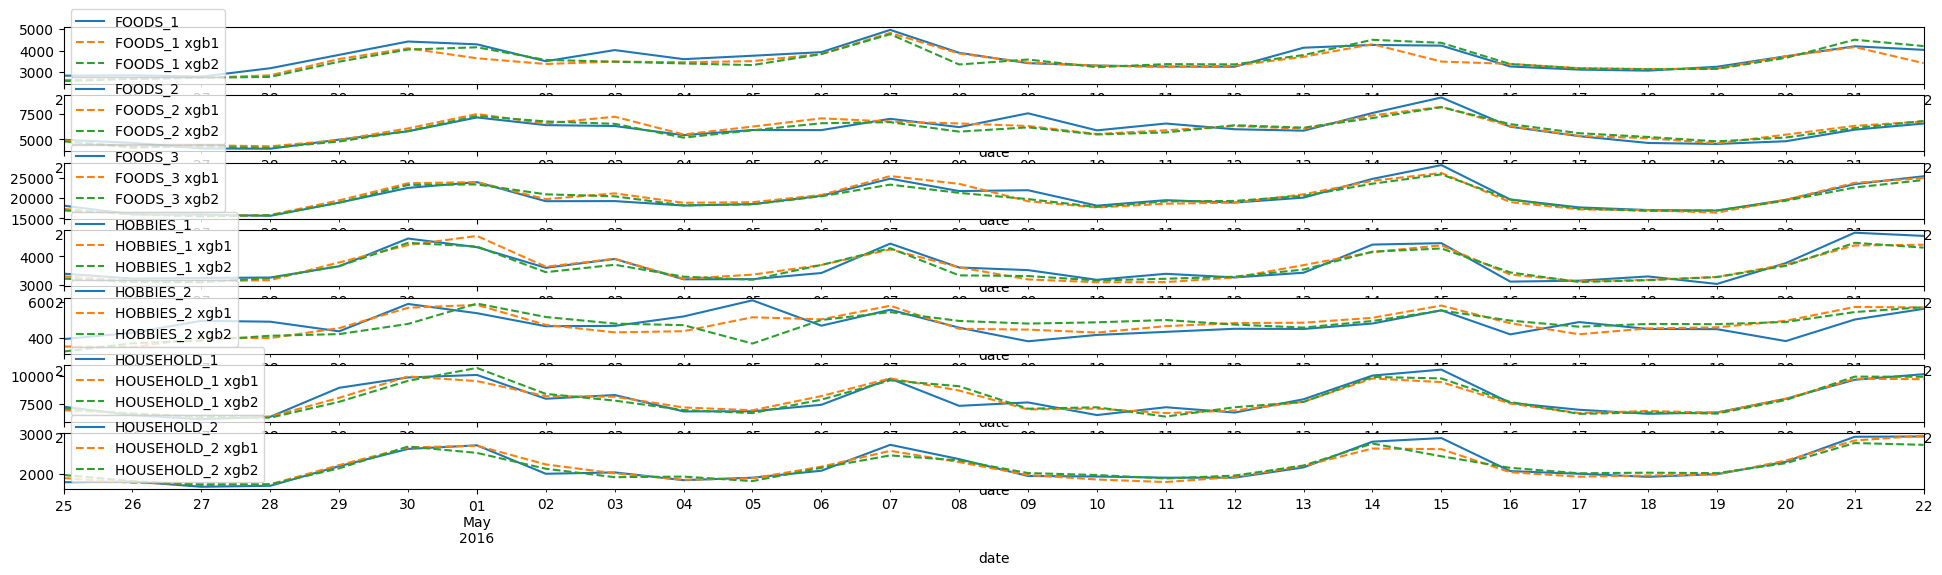

In [26]:
fig, ax = plt.subplots(len(df.dept_id.unique()), 1, figsize=(24,6))

for i, (name, group)in enumerate(y_test.groupby('dept_id')):
    group.plot(y='y_0', ax=ax[i], linestyle= 'solid', label=name)
    group.plot(y='xgb_1', ax=ax[i], linestyle= 'dashed', label=f'{name} xgb1')
    group.plot(y='xgb_2', ax=ax[i], linestyle= 'dashed', label=f'{name} xgb2')

plt.show()

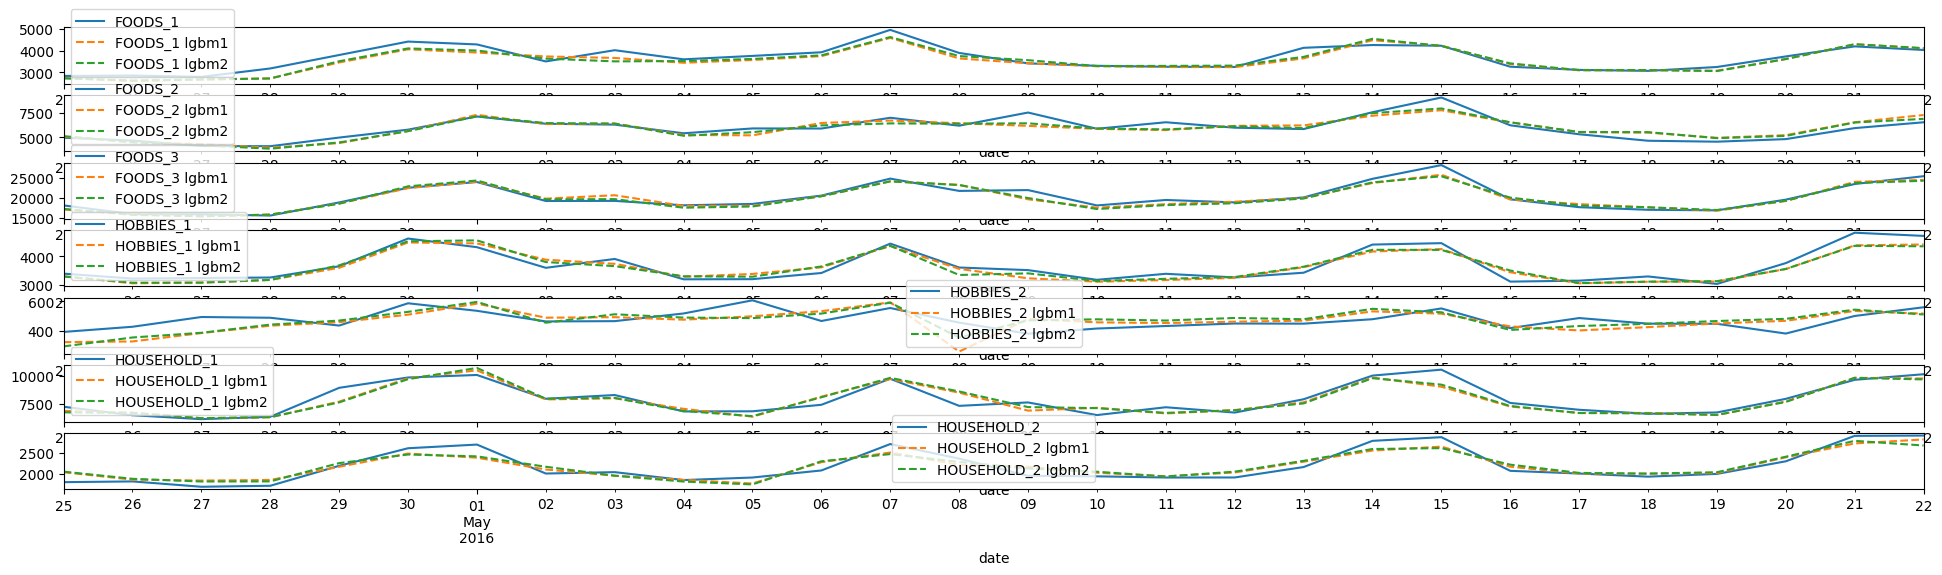

In [27]:
fig, ax = plt.subplots(len(df.dept_id.unique()), 1, figsize=(24,6))

for i, (name, group)in enumerate(y_test.groupby('dept_id')):
    group.plot(y='y_0', ax=ax[i], linestyle= 'solid', label=name)
    group.plot(y='lgbm_1', ax=ax[i], linestyle= 'dashed', label=f'{name} lgbm1')
    group.plot(y='lgbm_2', ax=ax[i], linestyle= 'dashed', label=f'{name} lgbm2')

plt.show()

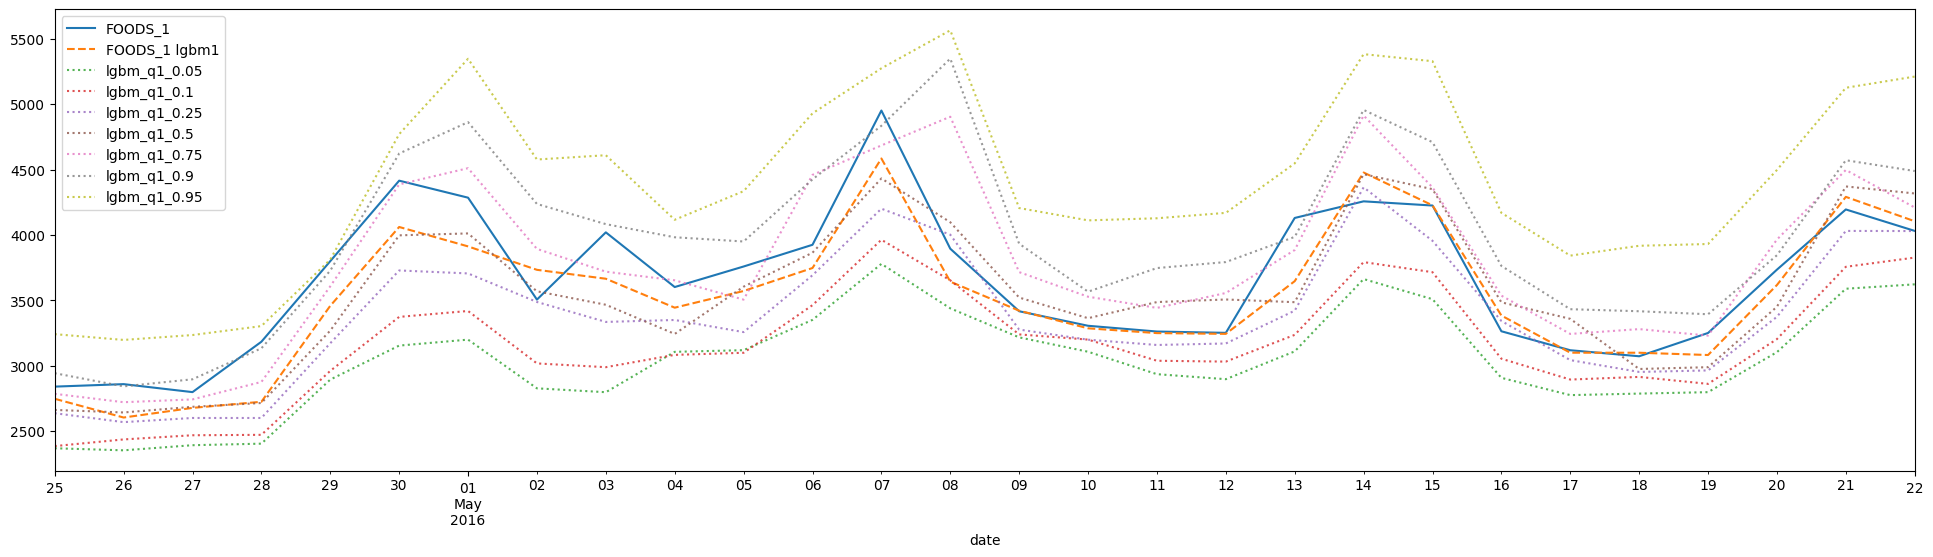

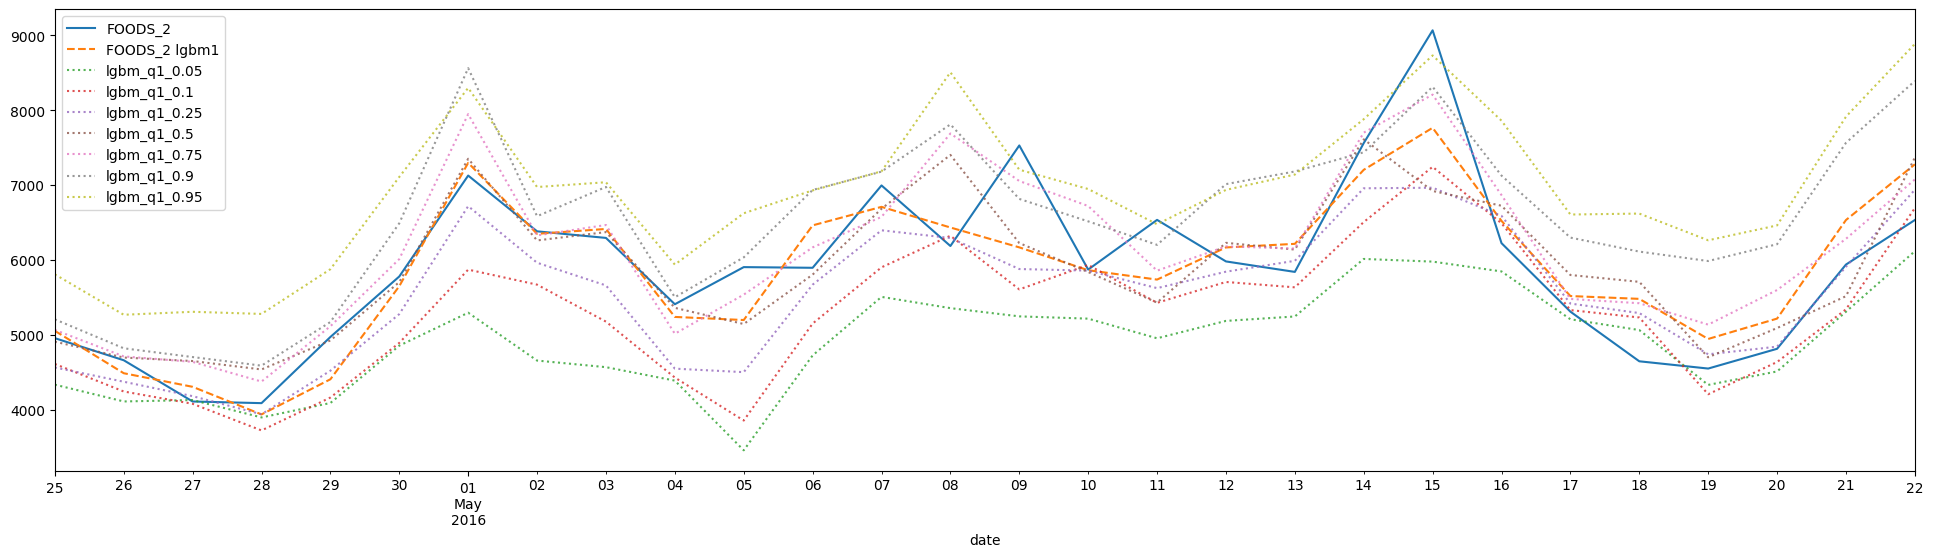

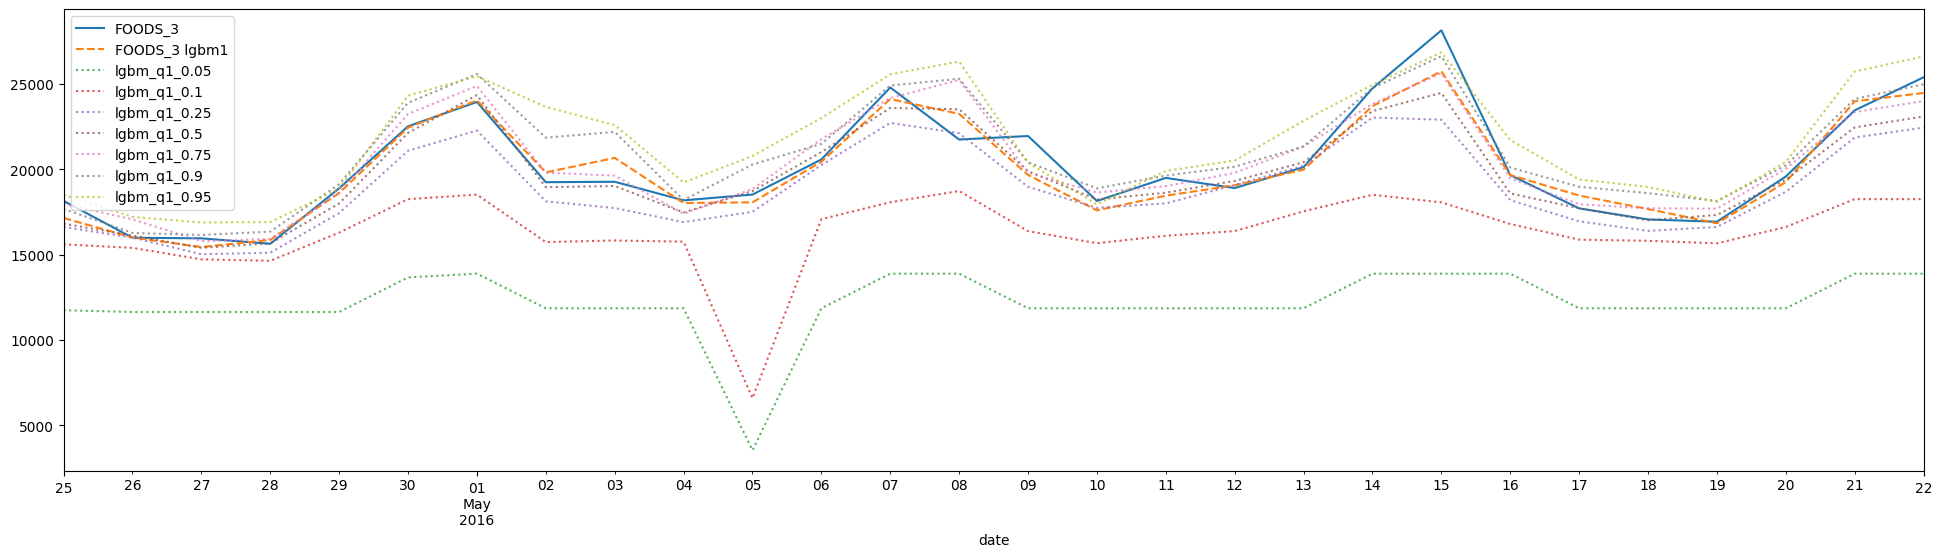

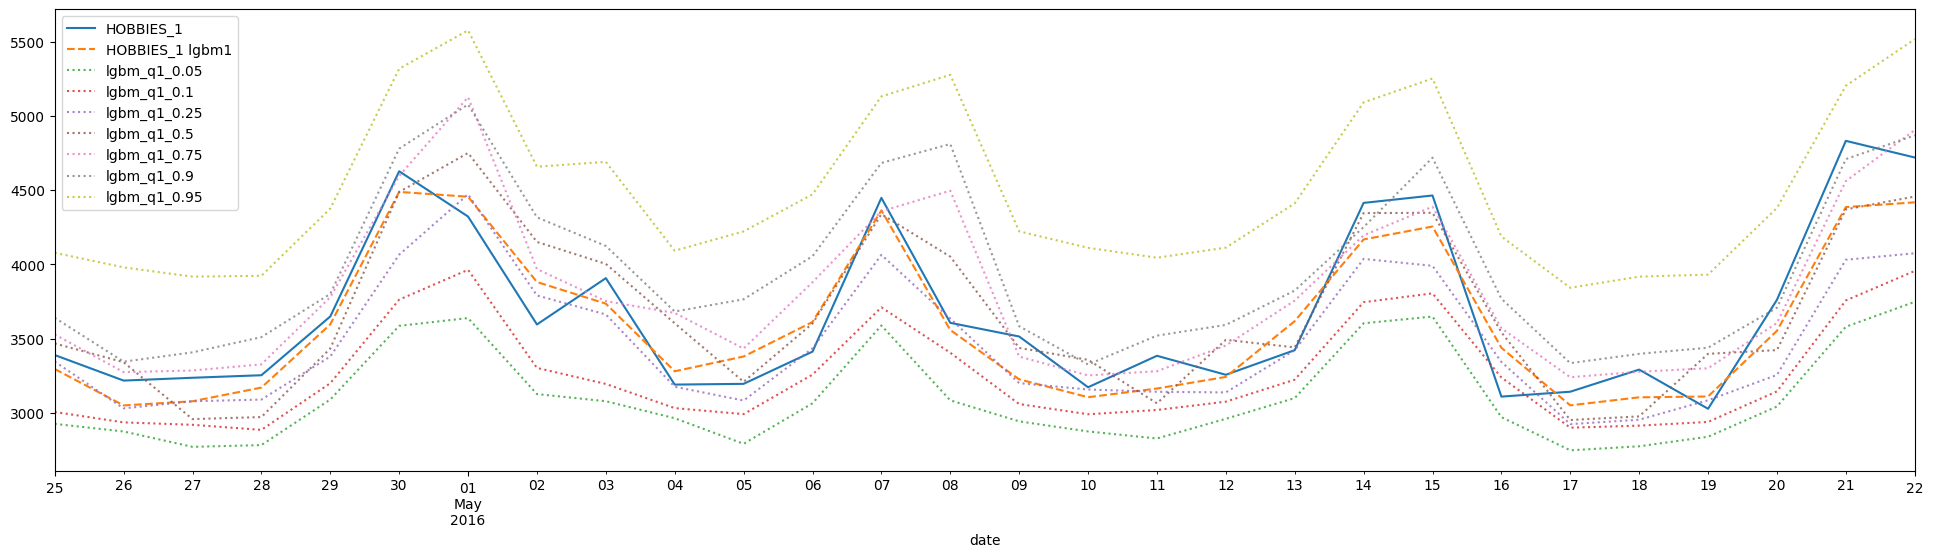

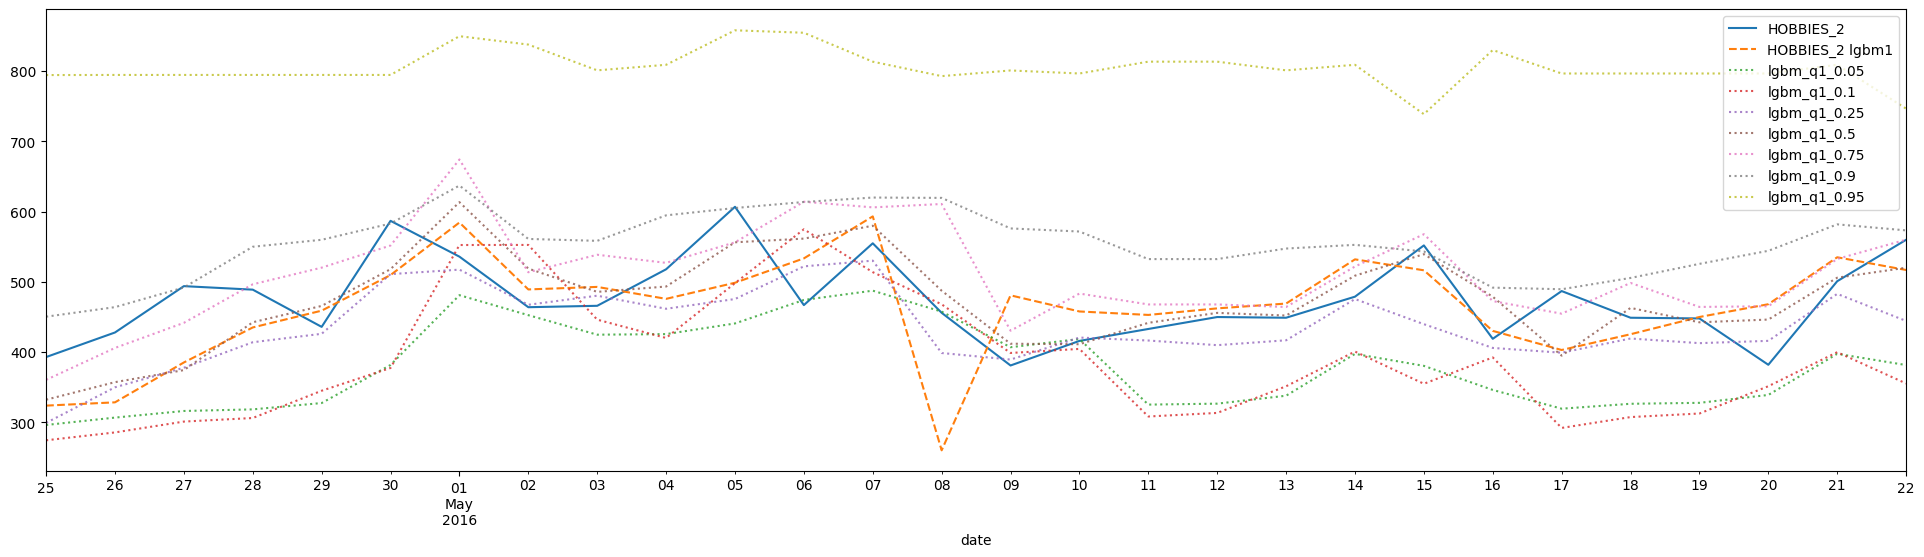

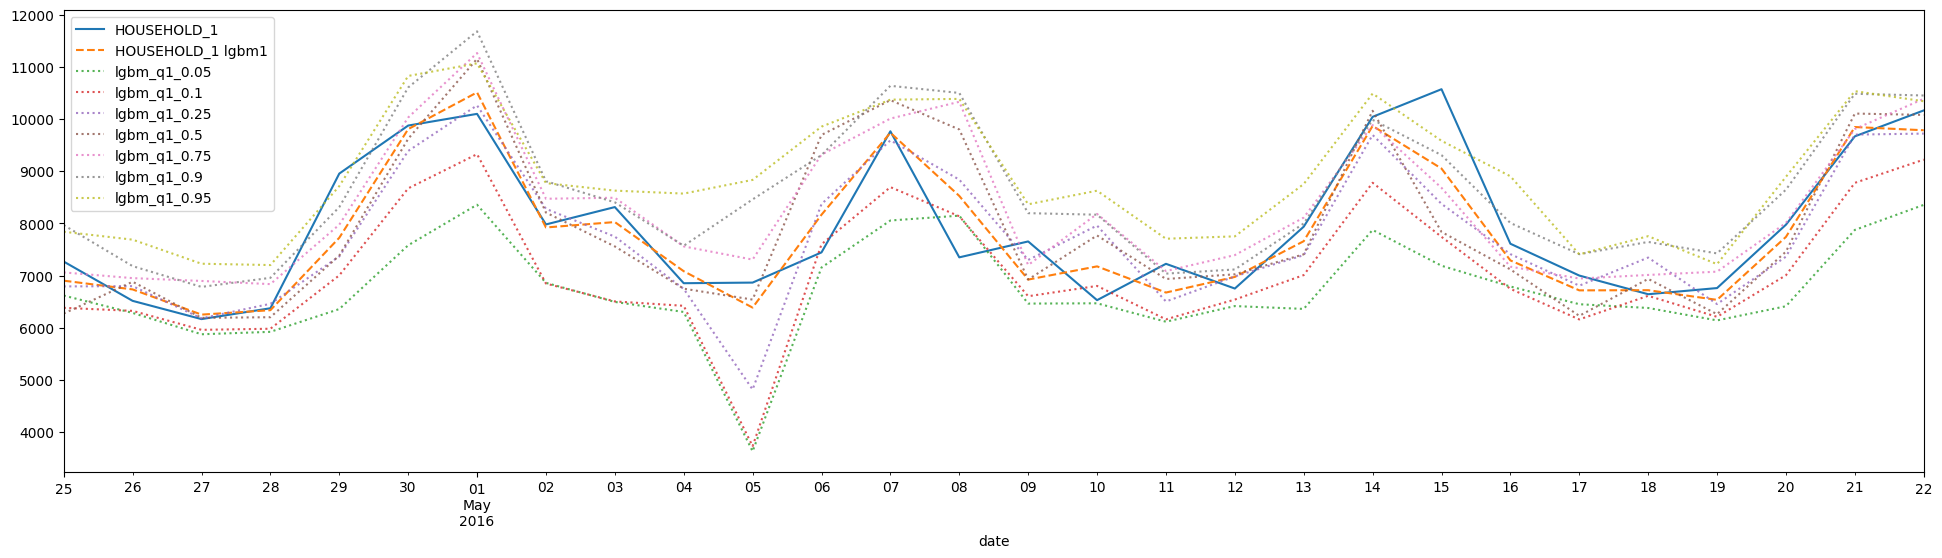

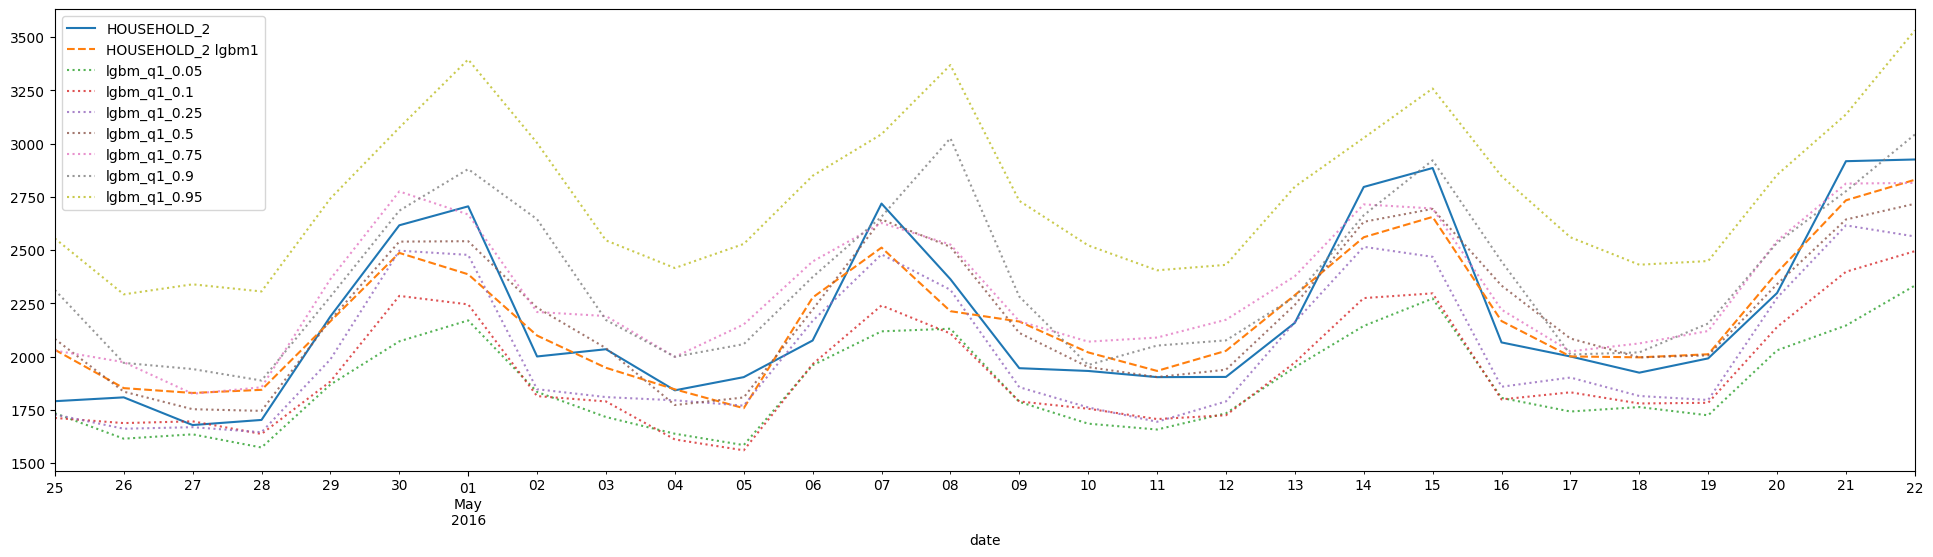

In [29]:
for (name, group) in y_test.groupby('dept_id'):
    fig, ax= plt.subplots(figsize=(24,6))
    group.plot(y='y_0', ax=ax, linestyle= 'solid', label=name)
    group.plot(y='lgbm_1', ax=ax, linestyle= 'dashed', label=f'{name} lgbm1')
    for col in [c for c in y_test.columns if 'q1' in c]:
        group.plot(y=col, ax=ax, linestyle= 'dotted', label=f'{col}', alpha=0.8)

plt.show()

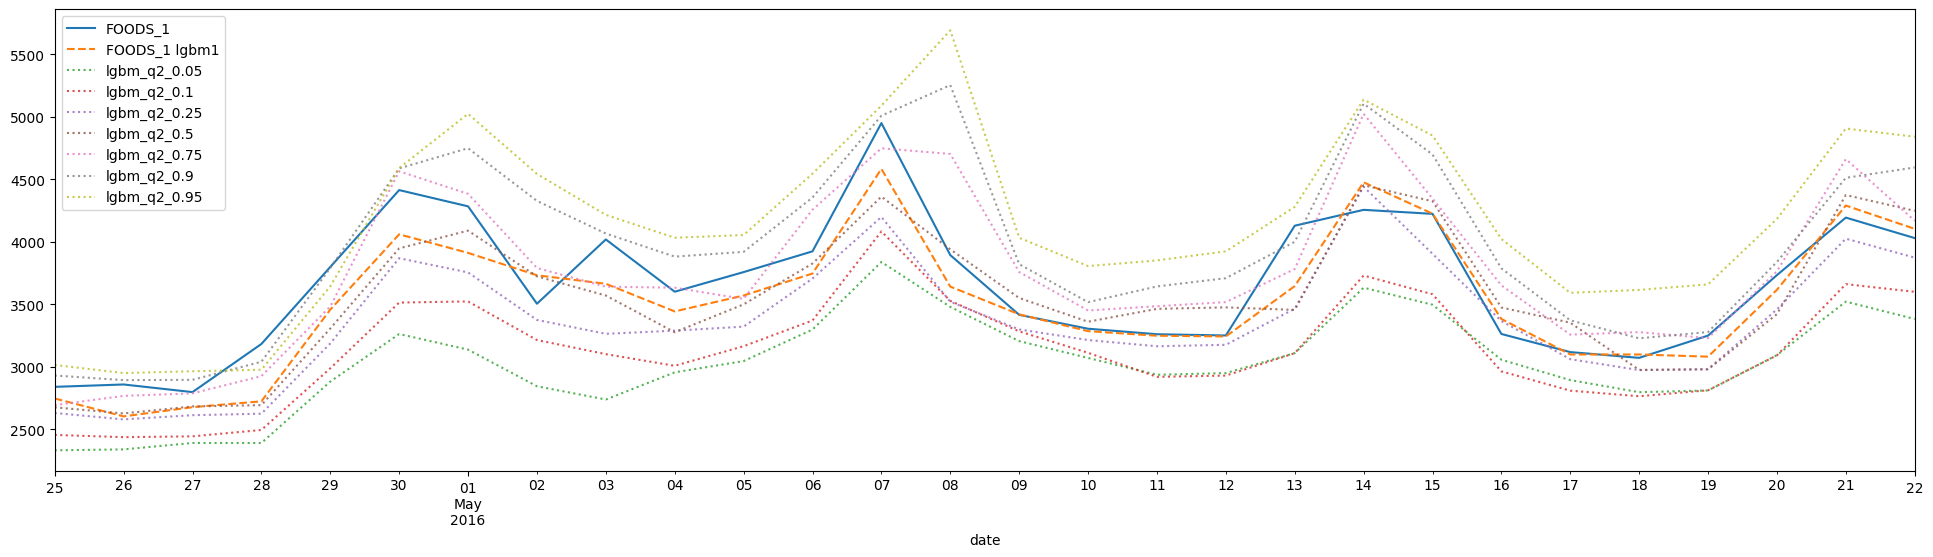

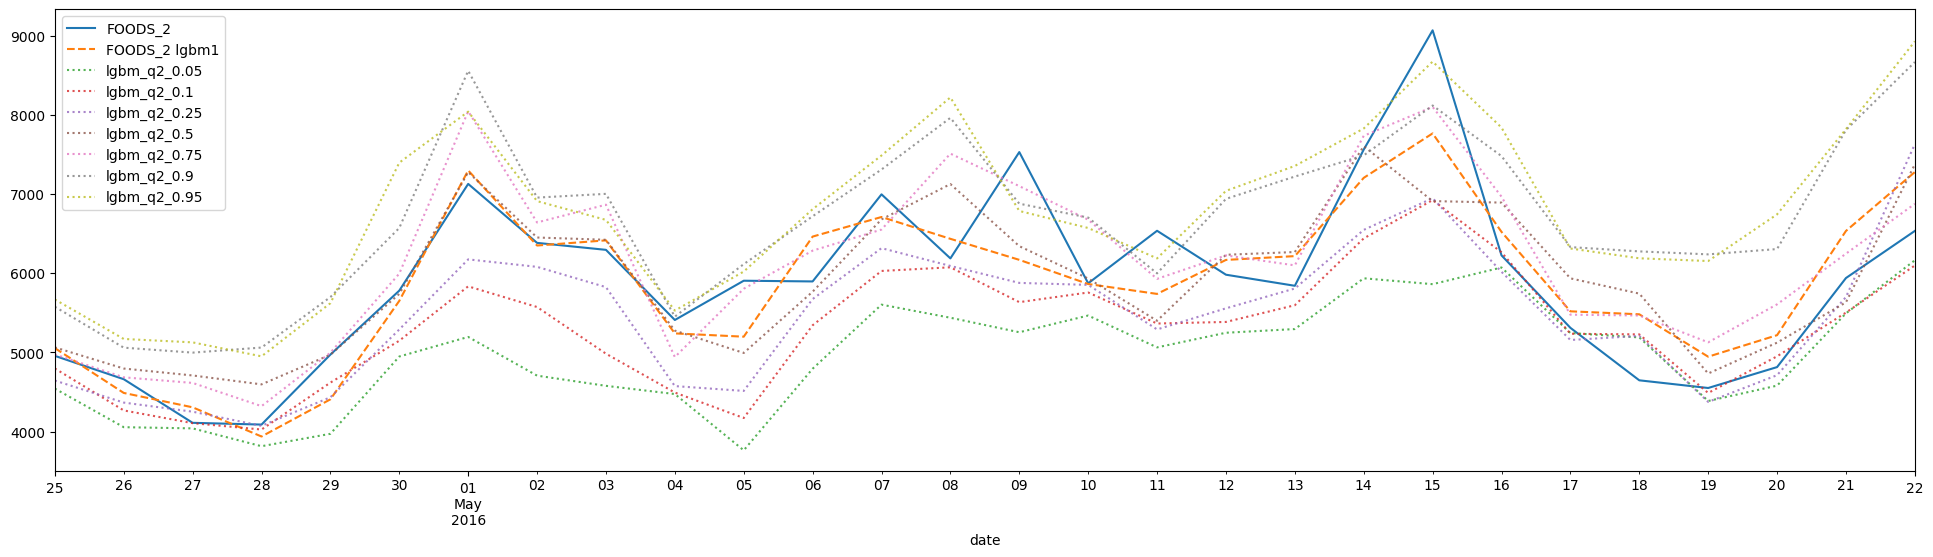

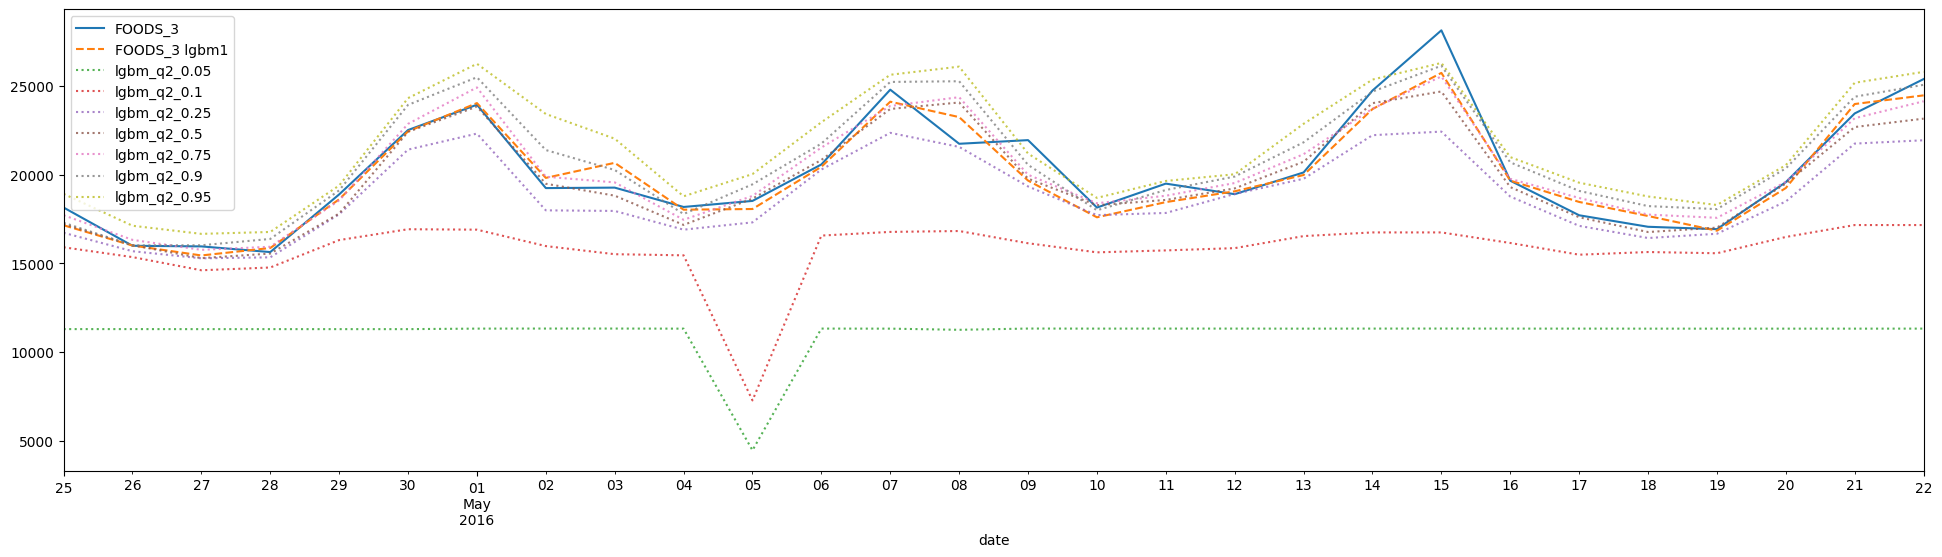

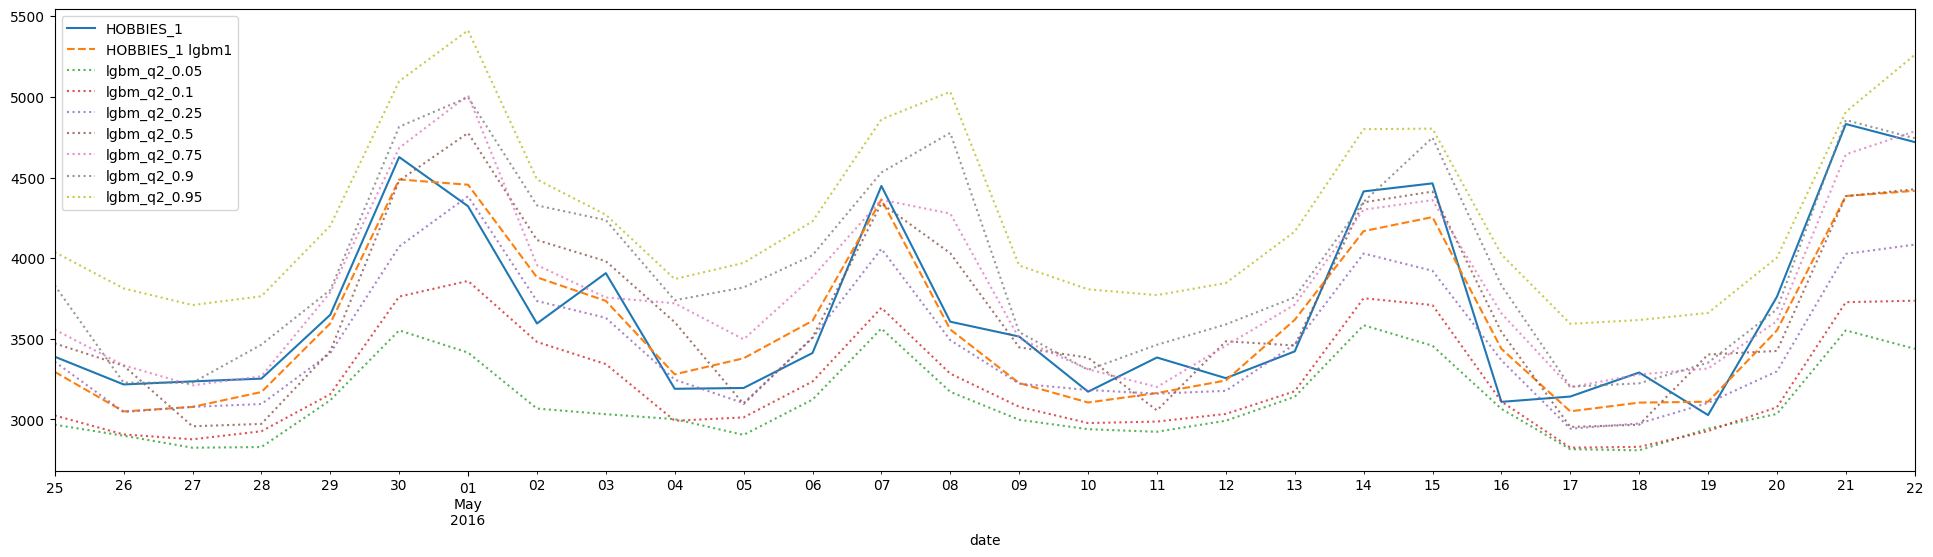

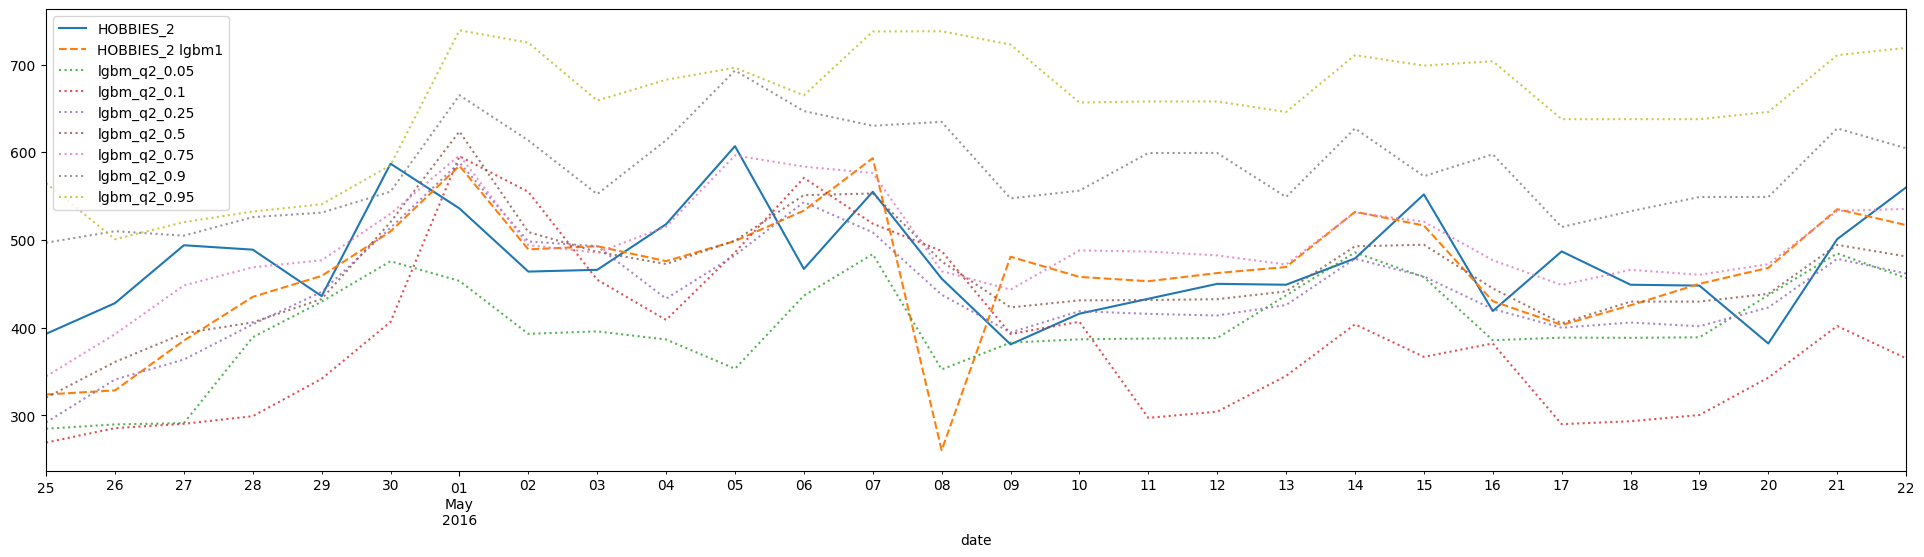

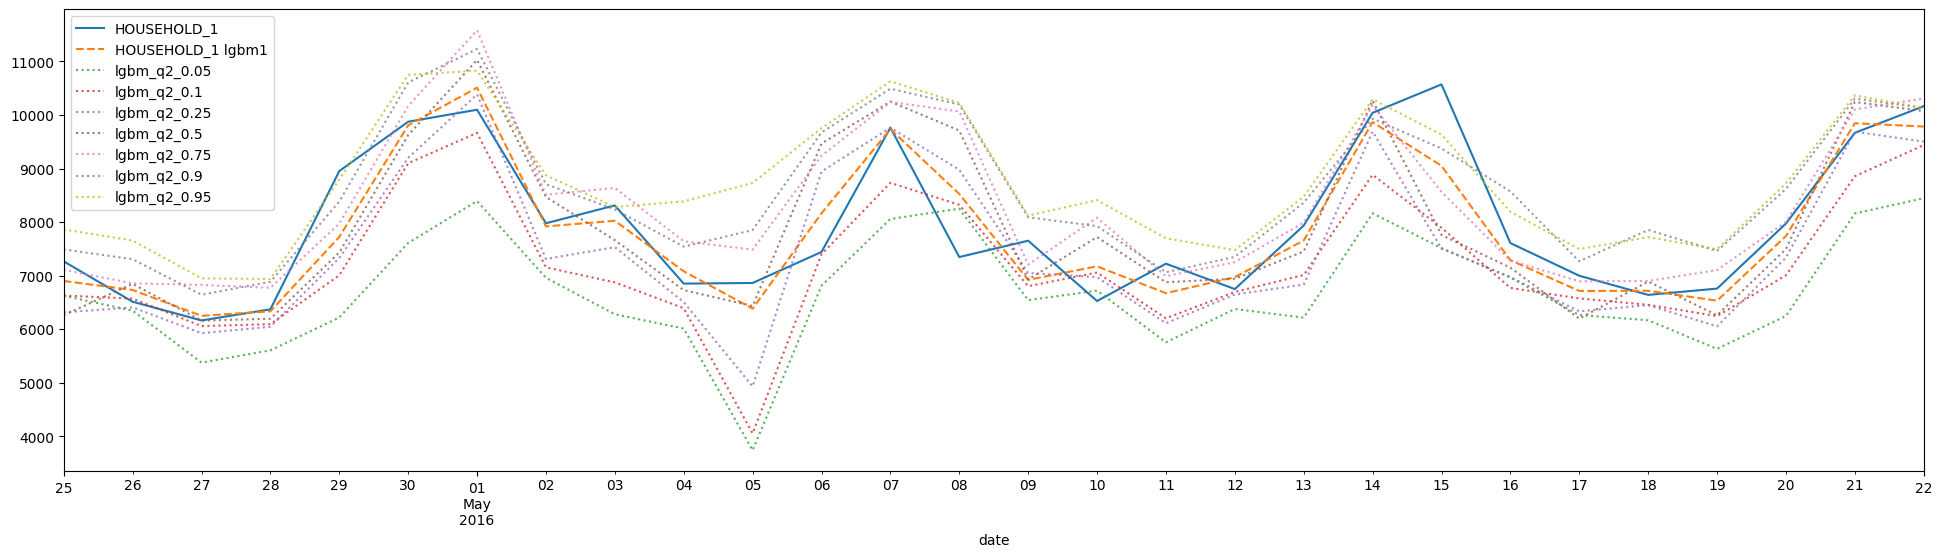

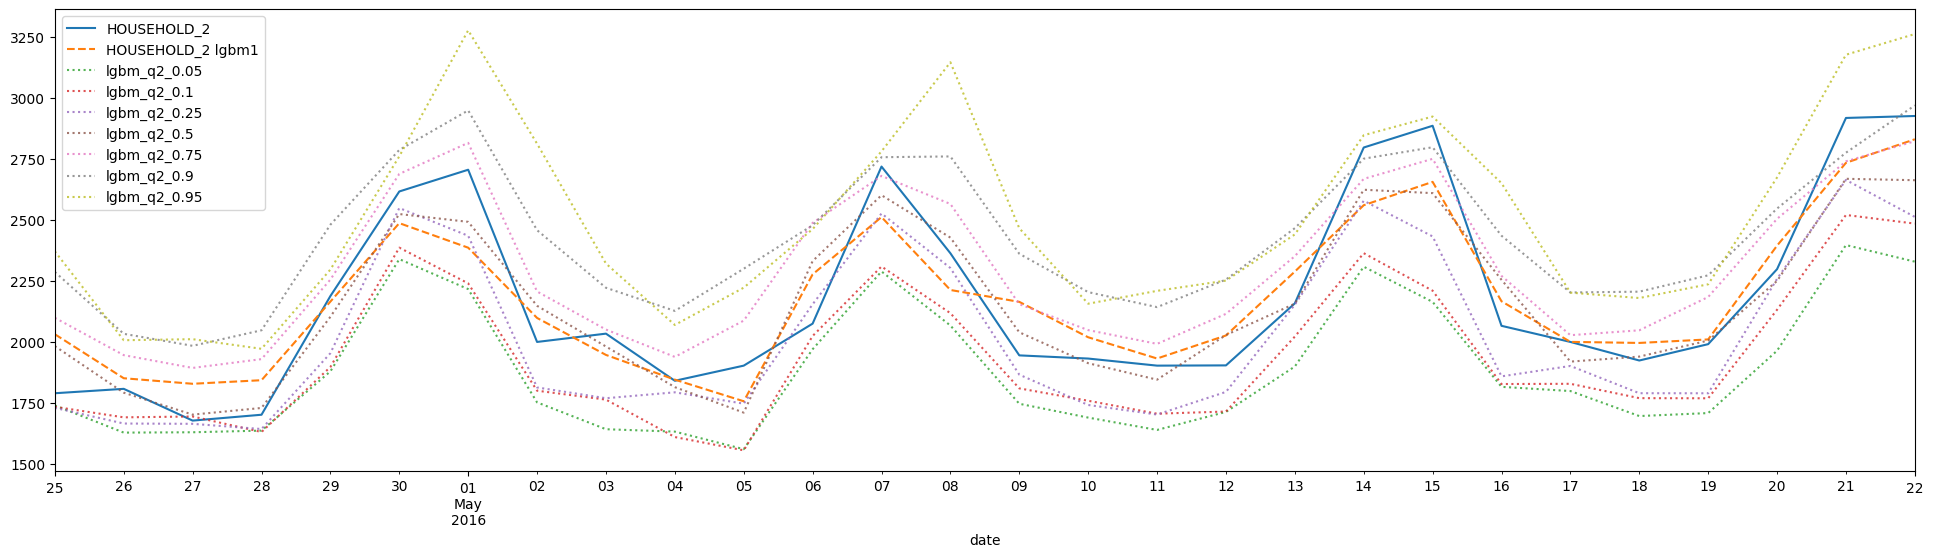

In [30]:
for (name, group) in y_test.groupby('dept_id'):
    fig, ax= plt.subplots(figsize=(24,6))
    group.plot(y='y_0', ax=ax, linestyle= 'solid', label=name)
    group.plot(y='lgbm_1', ax=ax, linestyle= 'dashed', label=f'{name} lgbm1')
    for col in [c for c in y_test.columns if 'q2' in c]:
        group.plot(y=col, ax=ax, linestyle= 'dotted', label=f'{col}', alpha=0.8)

plt.show()